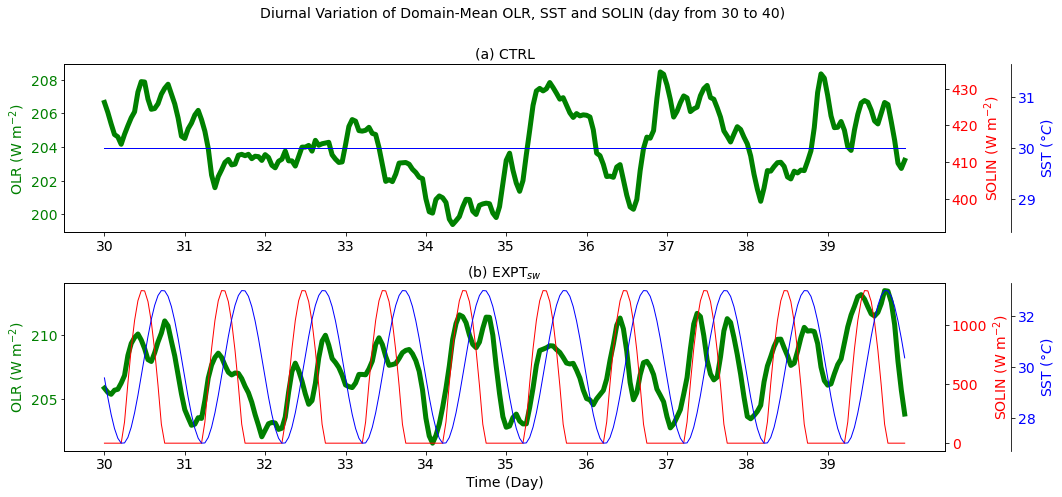

In [1]:
import numpy as np
import scipy.signal
import xarray as xr
import matplotlib.pyplot as plt

# Define constants
day_start = 30
day_end = 40
t1 = day_start * 24
t2 = day_end * 24

# Define cases
cases = [
    'SAM6108_RCE_MC_20221230_256x256',
#     'SAM6108_RCE_MC_20221230_256x256a',
#     'SAM6108_RCE_MC_20221230_256x256_DC',
    'SAM6108_RCE_MC_20221230_256x256_DCa'
]

# Function to load and process data for a given case
def load_case_data(case, t1, t2):
    path = f'/fs3/group/mullegrp/Bidyut_Goswami/sam_data/{case}/OUT_{case}/NETCDF_files/'
    f_in = f'{path}RCE_MC_{case}.nc'
    fin = xr.open_dataset(f_in)
    
    LWd = fin['RADLWDN']
    LWu = fin['RADLWUP']
    OLR_z = LWu - LWd
    OLR = OLR_z[t1:t2].mean(dim='z')
    SOLIN = fin['SOLIN'][t1:t2]
    SST = fin['SST'][t1:t2]
    
    period = t2 - t1
    OLRtmp = np.reshape(OLR.values, (int(OLR.shape[0] / period), period), order='F')
    OLRtmp2 = np.mean(OLRtmp, 0)
    
    return OLRtmp2, SST, SOLIN

# Load and process data for each case
data = []
for case in cases:
    OLRtmp2, SST, SOLIN = load_case_data(case, t1, t2)
    b, a = scipy.signal.butter(3, 0.1)
    OLR_lf = OLRtmp2 #scipy.signal.filtfilt(b, a, OLRtmp2)
    data.append((OLR_lf, SST, SOLIN))

# # Extract data for plotting
# (data11, data12, data13) = data[0]
# (data21, data22, data23) = data[1]
# (data31, data32, data33) = data[2]
# (data41, data42, data43) = data[3]

(data11, data12, data13) = data[0]
(data41, data42, data43) = data[1]

# Function to plot data
def plot_data(ax, data, title):
    OLR, SST, SOLIN = data
    ax1, ax2 = ax.twinx(), ax.twinx()
    
    ax2.spines.right.set_position(("axes", 1.075))
    
    ax.plot(OLR, color='green', linewidth=5)
    ax.set_ylabel('OLR (W m$^{-2}$)', color='green', fontsize=14)
    ax.tick_params(axis='y', labelcolor='green', labelsize=14)
    
    ax1.plot(SOLIN, color='red', linewidth=1)
    ax1.set_ylabel('SOLIN (W m$^{-2}$)', color='red', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    
    ax2.plot(SST - 273, color='blue', linewidth=1)
    ax2.set_ylabel('SST ($\degree C$)', color='blue', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=14)
    
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='x', labelcolor='k', labelsize=14)

# Create the figure and plot
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
fig.suptitle(f'Diurnal Variation of Domain-Mean OLR, SST and SOLIN (day from {day_start} to {day_end})', fontsize=14)

# titles = [
#     "(a) EXPT: SST is steady; SOLIN is steady",
#     "(b) EXPT: SST is steady; SOLIN is diurnally varying",
#     "(c) EXPT: SST is diurnally varying; SOLIN is steady",
#     "(d) EXPT: SST is diurnally varying; SOLIN is diurnally varying"
# ]

titles = [
    "(a) CTRL", #EXPT: SST is steady; SOLIN is steady",
    "(b) EXPT$_{sw}$" #": SST is diurnally varying; SOLIN is diurnally varying"
]

for ax, data, title in zip(axs, data, titles):
    plot_data(ax, data, title)


# Set x-axis ticks and labels
day_ticks = np.arange(0, 240, 24)
#default_x_ticks = range(len(day_ticks))
day_labels = np.arange(day_start, day_end)

for ax in axs:
    ax.set_xticks(day_ticks)
    ax.set_xticklabels(day_labels)

ax.set_xlabel('Time (Day)', fontsize=14)

fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust to accommodate the suptitle

#Saving figure
fig_directory='/fs3/home/bgoswami/work/20220913_SAM/SAM_Manuscript_01/Final_Figs'
figname="Figure_4"

plt.savefig(''+str(fig_directory)+'/'+str(figname)+'.svg', format="svg",transparent=True, dpi=1200)
!rsvg-convert -f pdf -o {fig_directory}/{figname}.pdf {fig_directory}/{figname}.svg
plt.show()
